In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


## Request HPC Resources

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='100GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=94G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.58:36784 --name dummy-name --nthreads 36 --memory-limit 93.13GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.58:36784,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load in data

In [84]:
import xarray as xr
import numpy as np



In [161]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp25_ssp585_tracers_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")

In [87]:
ds["z_bottom_up"]  = approximate_z_bottom_up(ds, dim = "sigma2_l")

In [96]:
ds = approximate_z(ds, dim = "sigma2_l")

In [124]:
ds_location = ds[["z", "z_bottom_up", "thkcello"]].isel(xh = 100, yh = 100)
ds_location = ds_location.where(ds_location.thkcello.fillna(0.0) > 0)

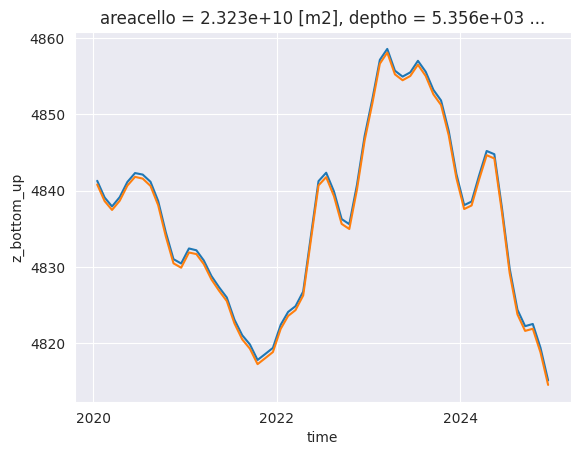

In [125]:
ds_location["z"].max(["sigma2_l"]).compute().plot()
(-ds_location["z_bottom_up"].min(["sigma2_l"]).compute()).plot()

In [121]:
ds_location["z"].idxmax(dim = "sigma2_l").compute()

<xarray.DataArray 'sigma2_l' (time: 60, yh: 180, xh: 240)> Size: 21MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) object 480B 2020-01-16 12:00:00 ... 2024-12-16 12:00:00
  * xh       (xh) int64 2kB 0 1 2 3 4 5 6 7 ... 232 233 234 235 236 237 238 239
  * yh       (yh) int64 1kB 0 1 2 3 4 5 6 7 ... 172 173 174 175 176 177 178 179